# Práctica 1

Procesamiento de Lenguaje Natural

Facultad de Ingeniería, UNAM

Alumno: Andrés González Flores

**Objetivo**: Obtener la curva de Zipf de los tipos de un corpus en escala logaríıtmica y determinar el parámetro α correspondiente a esa distribución.

Pasos a seguir:

1. Escoger un corpus de cualquier idioma y de un tamaño mayor a 10,000 tokens.
2. Limpiar el corpus: eliminar signos de puntuación, de interrogación, admiración y elementos no léxicos.
3. Aplicar un algoritmo de Stemming a los tokens limpios.
4. Obtener las frecuencias de los tipos en el corpus.
5. Ordenar por el rango estadístico de mayor a menor.
6. Graficar el diagrama de dispersión rango-frecuencia en la escala logarítmica.
7. Obtener el parámetro de la distribución de Zipf $\alpha$ (a partir de un procedimiento de regresión).




## Desarrollo

### Paso 1

El corpus que elegí se compone de 88 boletines de prensa de la campaña electoral de AMLO en las elecciones presidenciales de 2018.

Cada boletin tiene el siguiente formato:

```json
{
    "uuid" : "e58c384c-e99d-427a-98af-67ad7eca7b93",
    "fuente" : "https:\/\/lopezobrador.org.mx\/2018\/04\/02\/amlo-visita-el-municipio-de-santa-catarina-en-nuevo-leon\/",
    "fecha" : "2018\/04\/02",
    "encabezado" : "Asegura AMLO que en campaña todo será amor y paz, que los otros candidatos se ahorren sus provocaciones",
    "sumarios" : [
        "Adelanta López Obrador que no pasará nada el primero de julio cuando se lleven a cabo las elecciones presidenciales",
        "Expresa que esperará que Donald Trump se serene y lo hará entrar en razón","Invita a que se realice un encuentro público entre técnicos para debatir si es viable o no la construcción del nuevo aeropuerto en el Lago de Texcoco"
        ],
    "contenido" : "Andrés Manuel López Obrador, candidato a la Presidencia de México, inicia en Santa Catarina un recorrido por municipios de (...)"
}
```

De estos, se tomará únicamente su contenido

In [1]:
import pandas as pd
import re
from nltk import SnowballStemmer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:

data = pd.read_json('./Data/boletines-AMLO.json', encoding='utf-8', dtype='dict')
boletines = data['boletines']
corpus = "\n".join([ boletin['contenido'] for boletin in boletines ])

### Paso 2

Se consideran tokens que cumplan con la expresión regular \[a-zA-zñáéíóúüÁÉÍÓÚÜÑ\]+. Luego, se pasan a minúsculas.

In [3]:
tokens = re.findall('[a-zA-zñáéíóúüÁÉÍÓÚÜÑ]+', corpus)
tokens = [token.lower() for token in tokens]
tokens[:15]

['boletín',
 'campaña',
 'descargar',
 'audio',
 'discurso',
 'amlo',
 'ciudad',
 'juárez',
 'chihuahua',
 'de',
 'abril',
 'de',
 'palabras',
 'de',
 'andrés']

### Paso 3

Usaré el algoritmo de Snowball stemming de la librería nltk

In [4]:
es_stemmer = SnowballStemmer('spanish')
stems = [es_stemmer.stem(token) for token in tokens]
stems[:15]

['boletin',
 'campañ',
 'descarg',
 'audi',
 'discurs',
 'amlo',
 'ciud',
 'juarez',
 'chihuahu',
 'de',
 'abril',
 'de',
 'palabr',
 'de',
 'andres']

### Paso 4

Luego, usaré el módulo collections para crear un objeto Counter que me dé la frecuencia de los stems.

In [5]:
conteo_stems = Counter(stems)

### Paso 5

Ordeno los stems de mayor a menor frecuencia.

In [6]:
ordered_stems = sorted(conteo_stems.items(), key=lambda x: x[1], reverse=True) # El criterio a ordenar es la frecuencia
ordered_stems[:15]

[('de', 7305),
 ('que', 6942),
 ('la', 5037),
 ('a', 4379),
 ('el', 3953),
 ('y', 3611),
 ('se', 3282),
 ('en', 3093),
 ('los', 3029),
 ('no', 2313),
 ('del', 1496),
 ('par', 1476),
 ('es', 1347),
 ('con', 1244),
 ('por', 1167)]

### Paso 6

Grafico el rango de la palabra contra su frecuencia en escala logarítmica.

In [7]:
labels, frecs = zip(*ordered_stems)
ranks = np.arange(1, len(labels)+1) # Inicio en 1 para evitar errores de log(0)
log_ranks = np.log(ranks)
log_frecs = np.log(frecs)

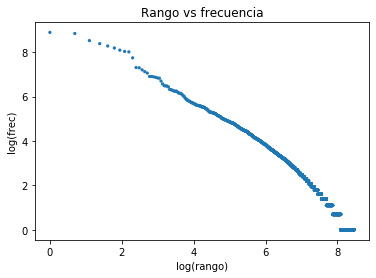

In [8]:
plt.figure()
plt.scatter(log_ranks, log_frecs, s=(5,5))
plt.xlabel('log(rango)')
plt.ylabel('log(frec)')
plt.title('Rango vs frecuencia')   

plt.show()

### Paso 7

Usaré el método de gradiente descendente para estimar el parámetro $\alpha$

El método de gradiente descendiente trata de encontrar un mínimo local de una función tomando pasos proporcionales al negativo del gradiente (o gradiente aproximado) de la función en el punto actual.

$$ \mathbf{\alpha}_{n+1} = \mathbf{\alpha}_n - \gamma \frac{\partial(J(\mathbf{\alpha}_n))}{\partial\alpha} $$

Donde $\gamma$ es el factor de aprendizaje.

**Función de aproximación:**

$$ \log \hat{fr} = \alpha \log r + \log b  $$

Donde $b$ es la mayor frecuencia en los datos y $\theta$ es un parámetro que aproxima la frecuencia en escala logaritmica.

**Función de costo:**

$$ J(\alpha) = MSE(\alpha) = \frac{1}{2n} \sum_r ( \log \hat{fr} - \log{fr} )^2 $$

Donde $n$ es el número de tipos en el corpus. 

Para minimizar esta función se requiere derivar la función de costo.

$$ \frac {\partial(J(\alpha))}{\partial\alpha} = \frac{1}{n} \sum_r \left( \alpha \log r + \log b - \log{fr}\right)\left(\log r\right)  $$

In [11]:
# Ordenada al origen
b = log_frecs[0]

# Función de aproximación
log_fr_aprox = lambda rank, alpha : alpha*np.log(rank) + b 

# Derivada de la función de aproximación
der_log_fr_aprox = lambda rank : np.log(rank) 

# Error cuadrático medio
MSE = lambda x, y, alpha : ((log_fr_aprox(x, alpha)-y)**2).sum(0)/(2*len(x))

# Derivada de MSE respecto a alpha
der_MSE = lambda x, y, alpha : ((log_fr_aprox(x, alpha)-y) * der_log_fr_aprox(x)).sum(0)/len(x)

# Método de gradiente descendente
def gradesc(xvect=[], yvect=[], alpha=1, lr=0.1, iterac=100, presc=0.001, verbosity=1):
    hist_alpha = []
    hist_error = []
    for i in range(iterac):
        alpha_actual = alpha
        alpha -= lr*der_MSE(xvect, yvect, alpha_actual)        
        error = MSE(xvect, yvect, alpha)
        
        if verbosity==1:
            print('Iteración %d' % (i+1))
            print('  alpha = %.4f' % (alpha))
            print('  MSE = %.5f' % (error))
            
        hist_alpha.append(alpha)
        hist_error.append(error)
        
        diff = alpha - alpha_actual
        if abs(diff) <= presc:
            break
    return [hist_alpha, hist_error]

In [12]:
alpha = 1
iters = 100
lr = 0.01
presc = 0.00001

hist_alpha, hist_error = gradesc(ranks, log_frecs, alpha, lr, iters, presc, verbosity=1)

Iteración 1
  alpha = -0.1355
  MSE = 21.48259
Iteración 2
  alpha = -0.6272
  MSE = 4.15719
Iteración 3
  alpha = -0.8401
  MSE = 0.90786
Iteración 4
  alpha = -0.9323
  MSE = 0.29845
Iteración 5
  alpha = -0.9723
  MSE = 0.18416
Iteración 6
  alpha = -0.9896
  MSE = 0.16273
Iteración 7
  alpha = -0.9971
  MSE = 0.15871
Iteración 8
  alpha = -1.0003
  MSE = 0.15795
Iteración 9
  alpha = -1.0017
  MSE = 0.15781
Iteración 10
  alpha = -1.0023
  MSE = 0.15778
Iteración 11
  alpha = -1.0026
  MSE = 0.15778
Iteración 12
  alpha = -1.0027
  MSE = 0.15778
Iteración 13
  alpha = -1.0028
  MSE = 0.15778
Iteración 14
  alpha = -1.0028
  MSE = 0.15778
Iteración 15
  alpha = -1.0028
  MSE = 0.15778


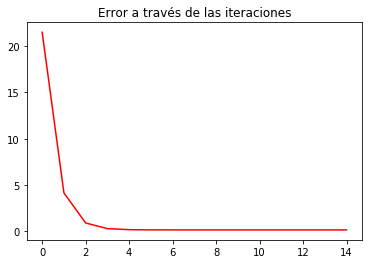

In [13]:
plt.title('Error a través de las iteraciones')
plt.plot(hist_error, color='r')
plt.show()

Imprimo el parámetro $\alpha$ que minimizó el error.

In [14]:
alpha = hist_alpha[-1]
alpha

-1.002788197803583

Grafico la aproximación vs datos empiricos

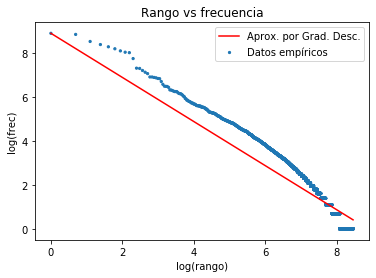

In [15]:
plt.figure()
plt.plot(log_ranks, alpha*log_ranks+b, color='r', label='Aprox. por Grad. Desc.')
plt.scatter(log_ranks, log_frecs, s=(5,5), label='Datos empíricos')
plt.xlabel('log(rango)')
plt.ylabel('log(frec)')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Rango vs frecuencia')   

plt.show()

### Paso extra: Divergencia KL

Calculo las probabilidades de los rangos con datos emríricos y con la aproximación de Zipf.

In [16]:
N = sum(frecs)
p_fr = np.array([float(fr)/N for fr in frecs])

p_zipf_gradesc = ranks**alpha
p_zipf_gradesc = p_zipf_gradesc/p_zipf_gradesc.sum(0)

In [17]:
#Divergencia KL
D_kl = lambda q,p: (q*np.log(q/p)).sum(0)

In [18]:
print('Divergencia frecuencia relativa y Zipf MSE approx \t', D_kl(p_fr, p_zipf_gradesc))

Divergencia frecuencia relativa y Zipf MSE approx 	 0.06892574017840974
